# Mines ParisTech - PSL

# Projet d'Optimisation - Rangement d'un tuyau de jardin

# Enol Alvarez & Louis-Justin Tallot

## 1. Etude du problème d'optimisation

### Q1) Interpréter le coût (4). Que cherche-t-on à minimiser ?

On cherche $min \left(K\left(x_N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum \limits _{i=0}^N y_i^2   \right)$.

Le premier terme correspond à la distance au parterre de fleurs et le deuxième à la distance à l'axe horizontal (qu'on appellera Distance verticale). On cherche donc à minimiser l'encombrement dans le jardin tout en assurant que le parterre de fleurs est arrosé.

### Q2) Pourquoi n'a-t-on pas plutôt imposé la contrainte $x_N = L/2$ ?

Si on avait imposé les 4 coordonnées des 2 points aux bouts, l'ensemble des solutions admissibles aurait été fortement réduit. Concrètement, la condition initiale où $y_i = 0$ pour tout i $\leq N$ (i.e. le segment aligné avec la droite des abscisses) ne serait plus envisageable car la contrainte sur la distance entre les points (égale à $\text{d}x$) imposerait une distance horizontale totale égale à $L$.

Plus généralement, cela aurait complexifié inutilement le choix d'une condition initiale, en fonction notamment de la valeur de $x_N$. Pour une condition initiale en triangle, un seul triangle régulier vérifierait les contraintes : le triangle isocèle (et non rectangle) de base $\frac{L}{2}$ et de hauteur $\dfrac{L\sqrt 3 }{4}$ pour $x_N = L/2$.

### Q3) Interpréter géométriquement la condition de courbure (5)

On impose une courbure maximale avec : 

$$
    (x_{i+1} - 2x_i + x_{i-1})^2 + (y_{i+1} - 2y_i + y_{i-1})^2 \leq \text{d}x^4 \gamma^2
$$

Pour justifier cette expression, on commence par paramétriser la trajectoire. Celle-ci est définie par:

$$
    f(t) = (x(t), y(t))
$$ 
avec 
$(x(n), y(n)) = (x_n, y_n)$ pour $n \in [\![0, N]\!]$.

La courbure moyenne locale d'une fonction est donnée par son laplacien (qui correspond à la dérivée seconde pour une fonction réelle). La condition de courbure revient alors à majorer la norme du Laplacien :

$$
\|\Delta f\|^2 \leq  \gamma^2
$$
$$
\|\Delta x\|^2 + \|\Delta y\|^2 \leq \gamma^2
$$

L'expession du laplacien pour une fonction discrète prend la forme:

$$
\Delta x = \dfrac{\dfrac{x_{i+1} - x_i}{\text{d}x} - \dfrac{x_i - x_{i-1}}{\text{d}x}}{\text{d}x} = \dfrac{x_{i+1} - 2x_i + x_{i-1}}{\text{d}x^2}
$$

D'où l'expression finale :

$$
\frac{(x_{i+1} - 2x_i + x_{i-1})^2}{\text{d}x^4} + \frac{(y_{i+1} - 2y_i + y_{i-1})^2}{\text{d}x^4} \leq  \gamma^2
$$

### Q4) Formuler le problème d'optimisation à résoudre sous la forme 

$$ \min \limits _{c_{eq}(z)=0,\; c_{ineq}(z)\leq0} f(z)$$

On pose : 

Variables de décision au nombre $n=2N+2$ : 
$$z = (x_0, \dots, x_N , y_0, \dots, y_N)$$  


Contraintes : 


$\begin{align} 
c_{eq}(z) &= c_{eq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0, y_0, y_N , (x_1-x_0)^2 + (y_1-y_0)^2-\text{d}x^2, \dots, (x_N-x_{N-1})^2 + (y_N-y_{N-1})^2-\text{d}x^2)
\end{align}$

 
et


$\begin{align} 
c_{ineq}(z) &= c_{ineq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0-x_1, \dots, x_{N-1}-x_N, 
          (x_2-2x_1+x_0)^2+(y_2-2y_1+y_0)^2- \text{d} x ^4 \gamma ^2, \dots, 
        (x_N-2x_{N-1}+x_{N-2})^2+(y_N-2y_{N-1}+y_{N-2})^2- \text{d} x ^4 \gamma ^2)
\end{align}$

Fonction objectif à minimiser : 

$\begin{align}
   f(z) &= f(x_0, \dots, x_N , y_0, \dots, y_N) \\
        &= K \left(x_N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum_{i=0}^N y_i^2 
 \end{align}$



## 2. Etude et résolution numériques

### Q5) Quelles méthodes de résolution peuvent être envisagées pour ce problème ?

On se trouve ici face à un problème d'optimisation avec des contraintes égalité et inégalité. 

On pourrait opter par un algorithme SQP, car on peut réécrire la fonction $f$ comme une fonction quadratique, mais les contraintes ne sont pas toutes affines. La matrice obtenue pour les termes quadratiques est positive mais n'est pas définie, ce qui pourrait poser problème pour la résolution.

On peut aussi envisager l'application de l'algorithme d'Uzawa. Cependant cet algorithme admet uniquement des contraintes inégalités (tel qu'on l'a vu dans le cours), il suffit alors de remplacer chaque contrainte égalité par 2 contraintes inégalité (l'une $\leq 0$ et l'autre $\geq 0$).

### Q6) Développer un algorithme de résolution pour les valeurs numériques suivantes : $L = 10$ ; $N = 60$ ; $K= 10$ et $\gamma = 3$

In [1]:
import casadi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.utils import io

In [2]:
# nos données
L = 10
N = 60
K = 10
gamma = 3

# on en déduit alors
dx = L/N

In [3]:
def conditions_initiales(L=10, N=60):
    """ Génère deux conditions initiales selon les paramètres :
    un triangle rectangle isocèle orienté vers le haut, et son 
    symétrique par rapport à l'axe des abscisses
    """
    dx = L/N   
    
    # On génère les ordonnées d'abord
    y = []
    ordonnee = 0
    while ordonnee <= L/(2*np.sqrt(2)): # partie montante
        y.append(ordonnee)
        ordonnee += dx / (np.sqrt(2))

    ordonnee = L/(2*np.sqrt(2)) - dx/(2*np.sqrt(2))
    while ordonnee >= 0: # partie descendante du triangle
        y.append(ordonnee)
        ordonnee -= dx/np.sqrt(2)

    if len(y) < N+1: # pour toujours avoir le bon nombre de points
        y.append(ordonnee)
        
    # On génère ensuite les abscisses du triangle   
    x = []
    abscisse = 0

    while abscisse <= L/(np.sqrt(2)):
        x.append(abscisse)
        abscisse += dx/np.sqrt(2)
    
    # on veut le bon nombre de points
    if not np.isclose(x[-1], L/(np.sqrt(2))): 
        x.append(L/(np.sqrt(2)))
    
    # on réunit les listes d'abscisses et ordonnées 
    # pour faire les deux triangles 
    z0_triangle_haut = np.array(y+x)
    z0_triangle_bas = np.array(list(-1.*np.array(y))+x)

    return z0_triangle_haut, z0_triangle_bas

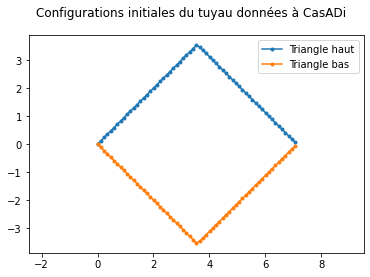

In [4]:
z0_triangle_haut, z0_triangle_bas = conditions_initiales()

X_haut = [z0_triangle_haut[i] for i in range(N+1, 2*N+2)]
Y_haut = [z0_triangle_haut[i] for i in range(0, N+1)]

X_bas = [z0_triangle_bas[i] for i in range(N+1, 2*N+2)]
Y_bas = [z0_triangle_bas[i] for i in range(0, N+1)]

plt.plot(X_haut, Y_haut, marker='.', label="Triangle haut")
plt.plot(X_bas, Y_bas, marker='.', label='Triangle bas')

plt.legend(loc='upper right')
plt.suptitle("Configurations initiales du tuyau données à CasADi")
plt.axis("equal")
plt.show()

In [13]:
def optim_simple(L=10, N=60, K=10, gamma=3, z0=None, plot=True, verbose=False, 
                 must_return=False, titre="Configuration optimale du tuyau trouvée par CasADi"):
    """ Optimisation avec CasADi, la configuration initiale par défaut étant un triangle"""
    dx = L/N

    if z0 is None:
        z0 = conditions_initiales(L, N)[0]

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K * (z[-1] - L/2)**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N] == 0) # y_N
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)
        opti.subject_to(z[1] >= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    


    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')

    if verbose:
        sol = opti.solve()
    else:
        with io.capture_output() as captured:
            sol = opti.solve()

    result = sol.value(z)

    if plot:
        plt.figure()
        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.')
        plt.axis('equal')
        plt.suptitle(titre)
        plt.show()
        print(f'Distance au parterre = {(result[2*N+1]-L/2)**2}') 
        y = [x**2 for x in result[0:N+1]]
        print(f'Distance verticale = {(dx**2)*sum(y)}')
        print(f'coût = {K*(result[2*N+1]-L/2)**2+(dx**2)*sum(y)}')

    if must_return:
        return result
    
   

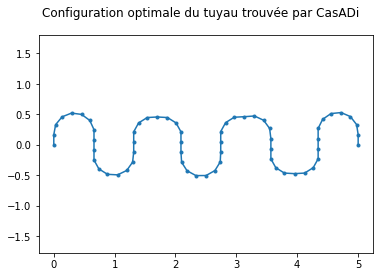

Distance au parterre = 4.354168917039065e-06
Distance verticale = 0.2050727496163808
coût = 0.2051162913055512


In [14]:
optim_simple()

### Q7) Refaire les simulations avec des valeurs différentes de K 

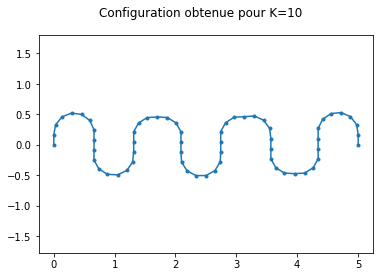

Distance au parterre = 4.354168917039065e-06
Distance verticale = 0.2050727496163808
coût = 0.2051162913055512


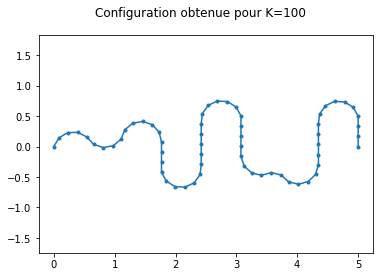

Distance au parterre = 5.799948917086269e-07
Distance verticale = 0.301391831196016
coût = 0.3014498306851868


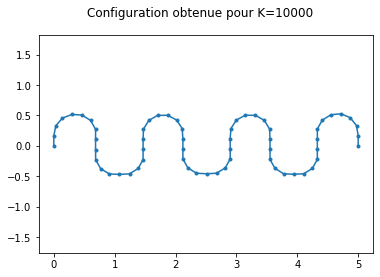

Distance au parterre = 2.647784634123931e-12
Distance verticale = 0.20508947547993558
coût = 0.20508950195778192


In [15]:
optim_simple(K=10, titre="Configuration obtenue pour K=10")
optim_simple(K=100, titre="Configuration obtenue pour K=100")
optim_simple(K=10000, titre="Configuration obtenue pour K=10000")

On constate que l'erreur $\left(x_N - \dfrac{L}{2}\right)$ diminue en fonction de $K$ alors que la distance verticale reste à peu près inchangée. Ce paramètre sert donc à imposer le coût lié à cette contrainte, et par conséquent à imposer la précision voulue du respect de cette contrainte.

### Q8) Refaire les simulations avec des valeurs différentes de N

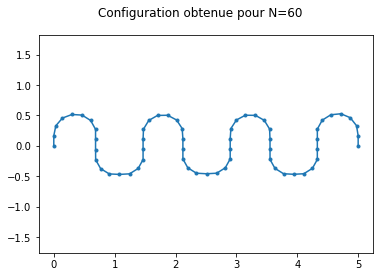

Distance au parterre = 2.647784634123931e-12
Distance verticale = 0.20508947547993558
coût = 0.20508950195778192


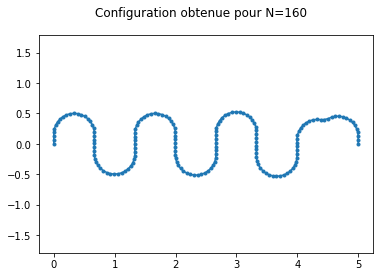

Distance au parterre = 1.173778405768954e-12
Distance verticale = 0.07628763389866855
coût = 0.07628764563645261


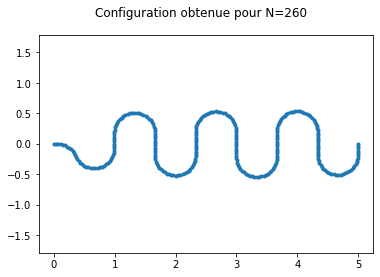

Distance au parterre = 2.1444649054680402e-12
Distance verticale = 0.04668461224039311
coût = 0.046684633685042165


In [17]:
optim_simple(N=60, K=10000, titre="Configuration obtenue pour N=60")
optim_simple(N=160, K=10000, titre="Configuration obtenue pour N=160")
optim_simple(N=260, K=10000, titre="Configuration obtenue pour N=260")

On retrouve le phénomène inverse à la question précédente : la distance verticale diminue en fonction de $N$, alors que l'erreur $\left(x_N - \dfrac{L}{2}\right)$ reste à peu près constante. L'augmentation du nombre de points de discrétisation, d'une part, augmente le coût lié à l'éloignement de l'axe des abscisses (car il y a plus de points qui ajoutent leur pénalité) et, d'autre part, donne plus de flexibilité à l'algorithme de résolution (qui peut par exemple se permettre de partir plus à l'horizontale au début tout en respectant la contrainte $y_1 \geq 0$).

### Q9) Modification de la condition initiale

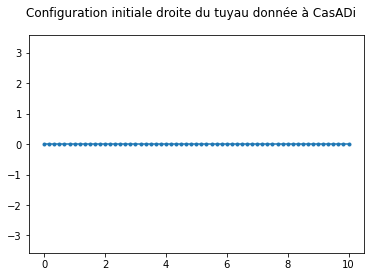

In [18]:
z0_droite = [0]*(N+1)+[i*dx for i in range(N+1)]
X = [z0_droite[i] for i in range(N+1, 2*N+2)]
Y = [z0_droite[i] for i in range(0, N+1)]
plt.plot(X, Y, marker='.')
plt.suptitle("Configuration initiale droite du tuyau donnée à CasADi")
plt.axis("equal")
plt.show()

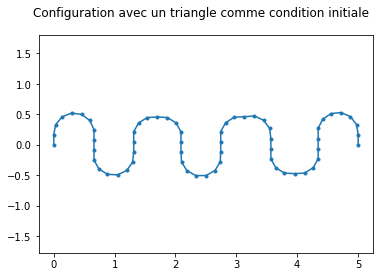

Distance au parterre = 4.354168917039065e-06
Distance verticale = 0.2050727496163808
coût = 0.2051162913055512


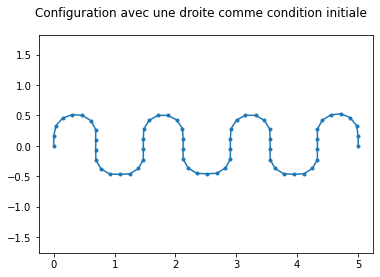

Distance au parterre = 2.660387512165652e-06
Distance verticale = 0.2049795162321243
coût = 0.20500612010724595


In [19]:
optim_simple(titre="Configuration avec un triangle comme condition initiale")

optim_simple(z0= z0_droite,titre="Configuration avec une droite comme condition initiale")

En partant de 2 conditions initiales totalement différentes, on constate qu'on obtient pratiquement la même solution. Autrement dit, cette solution semble être l'unique minimiseur global du problème et, en plus, le problème ne semble pas posséder des minima locaux où l'algorithme pourrait stagner. Le fait que le problème n'admette pas de minima locaux provient du fait que la fonction coût est convexe (en effet on pourrait réecrire la fonction comme une fonction quadratique, dont la matrice du terme quadratique est positive) et qu'elle est étudiée sur un ensemble convexe. 

## 3. Minimum global

### Q10) Optimisation avec parterre

In [20]:
x_P = 2
y_P = 1.3
R = 1

In [23]:
def optim_avec_parterre(L=10, N=60, K=10, gamma=3, x_P=2, y_P=0.2, R=0.3, z0=None, plot=True,verbose=False, 
                        must_return=False, title="Configuration optimale du tuyau trouvée par CasADi"):
    """ Optimisation avec CasADi prenant en compte la présence d'un parterre à éviter"""
    dx = L/N
    if z0 is None:
        z0 = conditions_initiales(L, N)[0]

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K * (z[-1] - L/2)**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N] == 0) # y_N
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    opti.subject_to(z[1]>=0)
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    

    # on rajoute le parterre de fleurs

    for i in range(N+1):
        opti.subject_to(R**2 - (x_P-z[N+1 +i])**2 - (y_P-z[i])**2  <= 0)
    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')
    if verbose:
        sol = opti.solve()
    else:
        with io.capture_output() as captured:
            sol = opti.solve()

    result = sol.value(z)

    if plot:
        plt.figure()
        # les couleurs pour que ça soit joli
        couleur_tuyau = "orange"
        # couleur_parterre = matplotlib.cm.gist_earth(0.6)
        couleur_parterre = matplotlib.cm.PiYG(0.999)


        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.', color=couleur_tuyau)
        plt.axis('equal')
        plt.suptitle(title)

        parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)


        legende_tuyau = plt.Line2D(range(1), range(1),
                                marker="o", color=couleur_tuyau)



        line1 = plt.Line2D([], [], color=couleur_tuyau, 
                        marker='o',markersize=5, markerfacecolor=couleur_tuyau)
        line2 = plt.Line2D([], [], color="white", 
                        marker='o',markersize=20,markerfacecolor=couleur_parterre)
        plt.legend((line1,line2),('Tuyau','Parterre de fleurs à éviter'))
        plt.gca().add_artist(parterre_fleurs)
        plt.show()
        print(f'Distance au parterre = {(result[2*N+1]-L/2)**2}') 
        y = [x**2 for x in result[0:N+1]]
        print(f'Distance verticale = {(dx**2)*sum(y)}')
        print(f'coût = {K*(result[2*N+1]-L/2)**2+(dx**2)*sum(y)}')


    if must_return:
        return result

Avec la nouvelle contrainte, d'ensemble des solutions admissibles n'est plus convexe. Donc il pourrait exister des minima locaux distincts du minimum global.

### Q11) Simulation avec le parterre

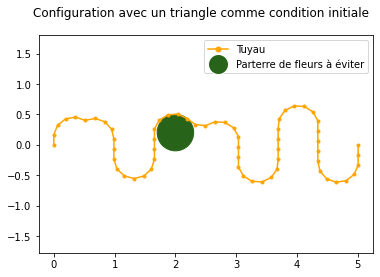

Distance au parterre = 2.1818927657436896e-05
Distance verticale = 0.25364774453580563
coût = 0.25386593381238


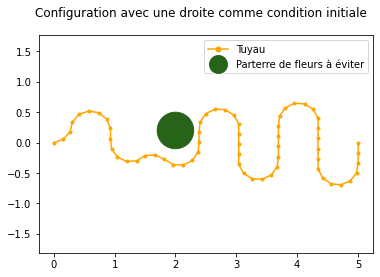

Distance au parterre = 1.784354910542006e-05
Distance verticale = 0.25210234652920294
coût = 0.2522807820202571


In [24]:
# optim_simple()
# optim_simple(gamma=10, N=1000)
# optim_simple(gamma=1)
# optim_simple(gamma=0.1)
# optim_simple(K=10, z0=np.array([0]*(N+1)+[i*dx for i in range(N+1)]))
optim_avec_parterre(title="Configuration avec un triangle comme condition initiale")
optim_avec_parterre(z0=z0_droite, title="Configuration avec une droite comme condition initiale")

On obtient 2 solutions différentes en partant de conditions initiales différentes pour lesquelles la fonction coût est minimisée (localement). Ceci montre bien que ce nouveau problème admet désormais des minima locaux. Notre algortihme ne converge donc plus nécéssairement vers un minimum global du problème.

### Q12) Génération aléatoire de conditions initiales

#### a) Justifier ce choix

Le but de ce nouvel algorithme ce sera de générer des conditions initiales différentes afin d'essayer de contourner les minima locaux et trouver éventuellement un minimiseur global. Pour cela, on a intérêt à augmenter le plus possible l'ensemble des conditions initiales admissibles afin d'élargir le champ de recherche de l'algorithme.

Comme on l'a déjà vu à la question 2, le fait d'imposer une contrainte réduit très fortement l'ensemble des conditions initiales admissibles, alors qu'en l'ajoutant à la fonction coût, on assure le respect (plus ou moins exact) de la condition tout en laissant intact l'ensemble des conditions initiales admissibles. 

Enfin en transformant une contrainte en coût on donne plus de flexibilité à l'algorithme grâce au paramètre $K_1$ qui permet d'ajuster la précision de cette contrainte.

En transportant une 2ème contrainte à la fonction coût on amplifie ce phénomène bénéfique.

#### b) Créer un algorithme utilisant la génération aléatoire de conditions initiales

In [14]:
def conditions_initiales_aleatoires(L=10, N=60, gamma=3, x_P=2, y_P=0.2, R=0.3):
    """Génère des conditions aléatoires qui respectent les contraintes"""
    dx = L/N   
    # on veut construire des conditions initiales aléatoires
    # qui respectent néamoins les contraintes
    # on veut une liste de longueur 2N+2
    trouve = True
    while True:
        res = [0.] * (2*N+2)

        # on va générer un point sur le bon cercle puis vérifier les contraintes 
        for i in range(1, N+1):
            theta = np.random.random() * np.pi  - np.pi/2
            new_x, new_y = res[N+1 + i-1] + dx * np.cos(theta), res[i-1] + dx * np.sin(theta)

            tries = 0
            while True:
                tries +=1
                count = 0
                if res[N+1 + i-1] - new_x <= 0 :
                    count += 1

                if i == 1 or (new_x - 2*res[N+1 + i-1] + res[N+1 + i-2])**2 + (new_y - 2*res[i-1] + res[i-2])**2 - dx**4 * gamma**2 <= 0 :
                    count += 1

                if R**2 - (x_P-new_x)**2 - (y_P-new_y)**2  <= 0:
                    count += 1

                if count == 3:
                    break

                if tries > 100:
                    trouve = False
                    break

                theta = np.random.random()  * np.pi - np.pi/2
                new_x, new_y = res[N+1 + i-1] + dx * np.cos(theta), res[i-1] + dx * np.sin(theta)


            res[N+1 + i], res[i] = new_x, new_y
            
            
        if trouve:
            break
        else:
            trouve=True
          
    
    return res

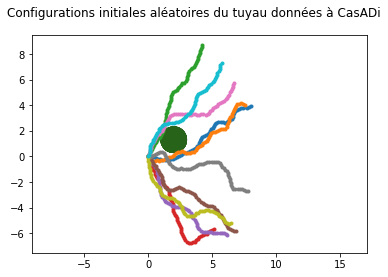

In [15]:
for i in range(10):
    z0_aleat = conditions_initiales_aleatoires(x_P = x_P, y_P = 1.3, R=1)
    X = [z0_aleat[i] for i in range(N+1, 2*N+2)]
    Y = [z0_aleat[i] for i in range(0, N+1)]
    
    plt.plot(X, Y, marker='.')
    parterre_fleurs = plt.Circle((x_P, 1.3), 1, color = matplotlib.cm.PiYG(0.999))
    plt.gca().add_artist(parterre_fleurs)
    
    plt.suptitle("Configurations initiales aléatoires du tuyau données à CasADi")
    plt.axis("equal")

plt.show()

In [16]:
def optim_avec_parterre_CI_aleatoires(L=10, N=60, K1=10, K2=10, gamma=3, x_P=2, y_P=0.2, R=0.3, z0=None, 
                                      plot=True, verbose=False, must_return=False, plot_CI=False):
    """Optimisation avec CasADI, prenant en compte le parterre et la nouvelle fonction, 
    utilisant des conditions initiales aléatoires par défaut
    """
    dx = L/N
    list_ligne_CI = []
    list_legende_CI = []

    if z0 is None: # on n'a pas donné de conditions initiales
        z0 = conditions_initiales_aleatoires(L, N, gamma, x_P, y_P, R)

    if plot_CI:
        color_CI = "dodgerblue"
        # on dessine la CI
        X = [z0[i] for i in range(N+1, 2*N+2)]
        Y = [z0[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.', color=color_CI)
        plt.suptitle("Configuration initiale du tuyau donnée à CasADi")
        plt.axis("equal")
        line_CI = plt.Line2D([], [], color=color_CI, 
                        marker='o',markersize=5, markerfacecolor=color_CI)
        list_ligne_CI = [line_CI]
        list_legende_CI = ["CI aléatoire"]

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K1 * (z[-1] - L/2)**2
    f += K2 * z[N]**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    

    # on rajoute le parterre de fleurs

    for i in range(N+1):
        opti.subject_to(R**2 - (x_P-z[N+1 +i])**2 - (y_P-z[i])**2  <= 0)
    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')
    if verbose:
        sol = opti.solve()
    else:
        with io.capture_output() as captured:
            sol = opti.solve()

    result = sol.value(z)

    if plot:
        # les couleurs pour que ça soit joli
        couleur_tuyau = "orange"
        # couleur_parterre = matplotlib.cm.gist_earth(0.6)
        couleur_parterre = matplotlib.cm.PiYG(0.999)

        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.', color=couleur_tuyau)
        plt.axis('equal')
        plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")

        parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)

        line1 = plt.Line2D([], [], color=couleur_tuyau, 
                        marker='o',markersize=5, markerfacecolor=couleur_tuyau)
        line2 = plt.Line2D([], [], color="white", 
                        marker='o',markersize=20,markerfacecolor=couleur_parterre)
        plt.legend(list_ligne_CI+[line1,line2],list_legende_CI+['Tuyau','Parterre de fleurs à éviter'])
        plt.gca().add_artist(parterre_fleurs)
        plt.show()
        print(f'x_N - L/2 = {result[2*N+1]-L/2}')
        print(f'y_N = {result[N]}')
        y = [x**2 for x in result[0:N+1]]
        print(f'distance verticale = {dx**2*sum(y)}')
        print("Minimiseur trouvé : ", K1*(result[2*N+1]-L/2)**2 + K2 * (result[N])**2 + dx**2*sum(y) )

    if must_return:
        return result, z0, sol.value(f)

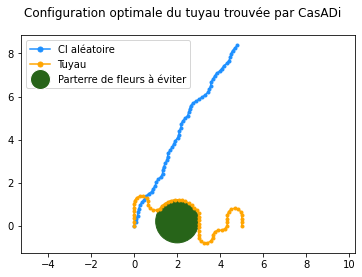

x_N - L/2 = 0.0006239366293696591
y_N = -0.007783721442498814
distance verticale = 1.0067296421782672
Minimiseur trouvé :  1.0073744350649583


In [17]:
optim_avec_parterre_CI_aleatoires(R=1,plot_CI=True, K1=100)

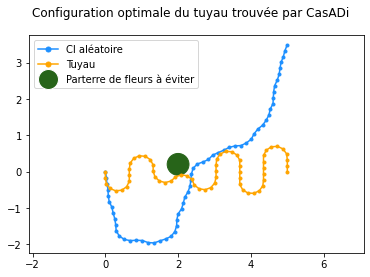

x_N - L/2 = 0.004460348028281658
y_N = -0.00682299372383428
distance verticale = 0.23253234400467185
Minimiseur trouvé :  0.23319682348356063


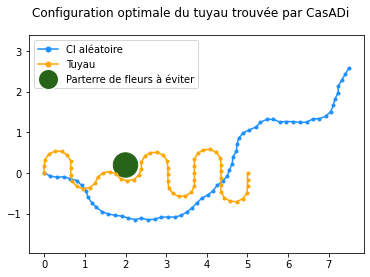

x_N - L/2 = 0.0009448639428732974
y_N = 0.007361833815899606
distance verticale = 0.2279842531326246
Minimiseur trouvé :  0.22861549589100805


In [18]:
optim_avec_parterre_CI_aleatoires(plot_CI= True, K1=10)
optim_avec_parterre_CI_aleatoires(plot_CI= True, K1=100)

On obtient une solution légérement meilleure que les 2 précédentes.

In [19]:
def optim_CI_aleatoire_avec_ajustement(nb_essais=5, L=10, N=60, K1=10, K2=10, gamma=3, x_P=2, y_P=0.2, R=0.3, z0=None, 
                                      plot=True, verbose=False, must_return=False, plot_CI=False, plot_multiple=False):
    """Optimisation avec la nouvelle fonction et le parterre ; on prend le meilleur
    résultat de plusieurs optimisations avec conditions initiales aléatoires
    """
    liste_essais_ci_min = []
    
    for i in range(nb_essais):
        liste_essais_ci_min.append(optim_avec_parterre_CI_aleatoires(L=L, N=N, K1=K1, K2=K2, gamma=gamma, x_P=x_P, y_P=y_P, R=R,
                                                                 z0=z0, plot=False, verbose=verbose, must_return=True, plot_CI=False))
    
    res_optimise = min(liste_essais_ci_min, key = lambda x:x[2])
    
    res = liste_essais_ci_min if plot_multiple else (res_optimise,)

    for indiv_res in res:
        tuyau = indiv_res[0]
        CI_indiv = indiv_res[1]
        
        
        list_ligne_CI = []
        list_legende_CI = []

        if plot_CI:
            color_CI = "dodgerblue"
            # on dessine la CI
            X = [CI_indiv[i] for i in range(N+1, 2*N+2)]
            Y = [CI_indiv[i] for i in range(0, N+1)]
            plt.plot(X, Y, marker='.', color=color_CI)

            plt.axis("equal")
            line_CI = plt.Line2D([], [], color=color_CI, 
                            marker='o',markersize=5, markerfacecolor=color_CI)
            list_ligne_CI = [line_CI]
            list_legende_CI = ["CI aléatoire"]

        if plot:

            # les couleurs pour que ça soit joli
            couleur_tuyau = "orange"
            # couleur_parterre = matplotlib.cm.gist_earth(0.6)
            couleur_parterre = matplotlib.cm.PiYG(0.999)


            X = [tuyau[i] for i in range(N+1, 2*N+2)]
            Y = [tuyau[i] for i in range(0, N+1)]
            plt.plot(X, Y, marker='.', color=couleur_tuyau)
            plt.axis('equal')
            plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")

    parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)

    line1 = plt.Line2D([], [], color=couleur_tuyau, 
                    marker='o',markersize=5, markerfacecolor=couleur_tuyau)
    line2 = plt.Line2D([], [], color="white", 
                    marker='o',markersize=20,markerfacecolor=couleur_parterre)
    plt.legend(list_ligne_CI+[line1,line2],list_legende_CI+['Tuyau','Parterre de fleurs à éviter'])
    plt.gca().add_artist(parterre_fleurs)
    plt.show()
    print(f'x_N - L/2 = {res_optimise[0][2*N+1]-L/2}')
    print(f'y_N = {res_optimise[0][N]}')
    y = [x**2 for x in res_optimise[0][0:N+1]]
    print(f'Distance verticale = {dx**2*sum(y)}')
    print("Minimiseur trouvé : ", K1*(res_optimise[0][2*N+1]-L/2)**2 + K2 * (res_optimise[0][N])**2 + dx**2*sum(y) )
    
    if must_return:
        return res_optimise

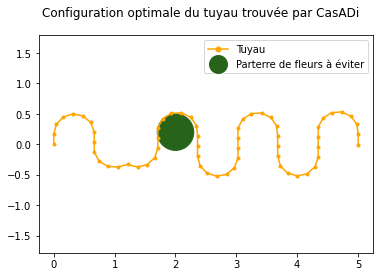

x_N - L/2 = 0.0016890691439304106
y_N = -0.004190120605582253
Distance verticale = 0.2029709234035595
Minimiseur trouvé :  0.2031750240561825


In [20]:
optim_CI_aleatoire_avec_ajustement()

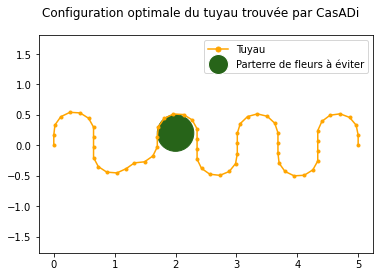

x_N - L/2 = 1.7765251811852067e-06
y_N = -3.8543173854400806e-06
Distance verticale = 0.20391275468320083
Minimiseur trouvé :  0.2039129348012431


In [21]:
optim_CI_aleatoire_avec_ajustement(K1=10000, K2=10000)

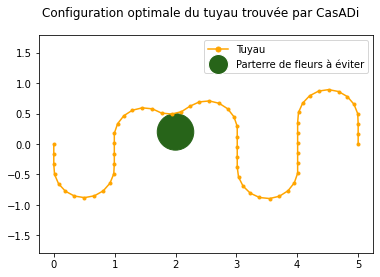

x_N - L/2 = 0.0011675237937991412
y_N = -0.0010825717633956245
Distance verticale = 0.5586947790139709
Minimiseur trouvé :  0.5589482863571698


In [22]:
optim_CI_aleatoire_avec_ajustement(K1=100, K2=100, gamma=2)

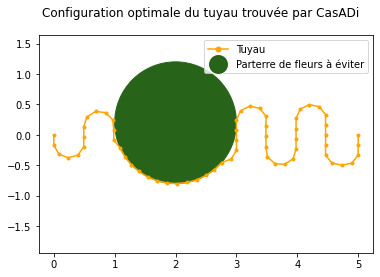

x_N - L/2 = 0.00011586338208413594
y_N = 0.0003416632956158067
Distance verticale = 0.2699189510118325
Minimiseur trouvé :  0.2699319668249204


In [23]:
optim_CI_aleatoire_avec_ajustement(K1=100, K2=100, gamma=4, R = 1)